In [6]:
import os
import torch
import argparse
import numpy as np
import torch.utils.data
import torch.nn.functional as F

from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [81]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [364]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_size, hid_size):
        super(AutoEncoder, self).__init__()
        """
        Here you should define layers of your autoencoder
        Please note, if a layer has trainable parameters, it should be nn.Linear. 
        ## !! CONVOLUTIONAL LAYERS CAN NOT BE HERE !! ##
        However, you can use any noise inducing layers, e.g. Dropout.

        Your network must not have more than six layers with trainable parameters.
        :param inp_size: integer, dimension of the input object
        :param hid_size: integer, dimension of the hidden representation
        """
        hid_size1 = 800
        hid_size2 = 800
        
        self.lin1  = nn.Linear(inp_size, hid_size1)
#         self.bn1   = nn.BatchNorm1d(hid_size1)
        self.drop1 = nn.Dropout(0.5)
        
        self.lin2  = nn.Linear(hid_size1, hid_size2)
#         self.bn2   = nn.BatchNorm1d(hid_size2)
        self.drop2 = nn.Dropout(0.5)
        
        self.lin3  = nn.Linear(hid_size2, hid_size)
        
        self.lin4  = nn.Linear(hid_size, hid_size2)
#         self.bn4   = nn.BatchNorm1d(hid_size2)
        self.drop4 = nn.Dropout(0.5)
        
        self.lin5  = nn.Linear(hid_size2, hid_size1)
#         self.bn5   = nn.BatchNorm1d(hid_size1)
        self.drop5 = nn.Dropout(0.5)        
        
        self.lin6  = nn.Linear(hid_size1, inp_size)
        
        self.recon_loss = nn.MSELoss()
        self.l1_lambda = 1e-6

    def encode(self, x):
        """
        Encodes objects to hidden representations (E: R^inp_size -> R^hid_size)

        :param x: inputs, Variable of shape (batch_size, inp_size)
        :return:  hidden represenation of the objects, Variable of shape (batch_size, hid_size)
        """
        x = self.drop1(F.relu(self.lin1(x)))
        x = self.drop2(F.relu(self.lin2(x)))
        return self.lin3(x)

    def decode(self, h):
        """
        Decodes objects from hidden representations (D: R^hid_size -> R^inp_size)

        :param h: hidden represenatations, Variable of shape (batch_size, hid_size)
        :return:  reconstructed objects, Variable of shape (batch_size, inp_size)
        """
        h = self.drop4(F.relu(self.lin4(h)))
        h = self.drop5(F.relu(self.lin5(h)))
        return self.lin6(h)

    def forward(self, x):
        """
        Encodes inputs to hidden representations and decodes back.

        x: inputs, Variable of shape (batch_size, inp_size)
        return: reconstructed objects, Variable of shape (batch_size, inp_size)
        """
        return self.decode(self.encode(x))
    
    def loss_function(self, recon_x, x):
        """
        Calculates the loss function.

        :params recon_x: reconstructed object, Variable of shape (batch_size, inp_size)
        :params x: original object, Variable of shape (batch_size, inp_size)
        :return: loss
        """
        l1_reg = Variable(torch.FloatTensor(1), requires_grad=True).cuda()
        for w in self.parameters():
            l1_reg = l1_reg + w.norm(1)
        return self.recon_loss(recon_x, x) + self.l1_lambda * l1_reg

In [365]:
def train(model, optimizer, train_loader, test_loader):
    for epoch in range(10):
        model.train()
        train_loss, test_loss = 0, 0
        for data, _ in train_loader:
            data = Variable(data).view(-1, 784).cuda()
            x_rec = model(data)
            loss = model.loss_function(x_rec, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
        print('=> Epoch: %s Average loss: %.6f' % (epoch, train_loss / len(train_loader.dataset)))

        model.eval()
        for data, _ in test_loader:
            data = Variable(data, volatile=True).view(-1, 784).cuda()
            x_rec = model(data)
            test_loss += model.loss_function(x_rec, data).data[0]

        test_loss /= len(test_loader.dataset)
        print('=> Test set loss: %.6f' % test_loss)

        n = min(data.size(0), 8)
        comparison = torch.cat([data.view(-1, 1, 28, 28)[:n], x_rec.view(-1, 1, 28, 28)[:n]])
        if not os.path.exists('./pics'): os.makedirs('./pics')
        save_image(comparison.data.cpu(), 'pics/reconstruction_' + str(epoch) + '.png', nrow=n)
    return model

In [366]:
def test_work():
    print('Start test')
    get_loader = lambda train: torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=train, download=True, transform=transforms.ToTensor()),
        batch_size=50, shuffle=True)
    train_loader, test_loader = get_loader(True), get_loader(False)
    
    try:
        model = AutoEncoder(inp_size=784, hid_size=20).cuda()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
    except Exception:
        assert False, 'Error during model creation'
        return

    try:
        model = train(model, optimizer, train_loader, test_loader)
    except Exception:
        assert False, 'Error during training'
        return

    test_x = Variable(torch.randn(1, 784)).cuda()    
    rec_x, hid_x = model(test_x), model.encode(test_x)
    submodules = dict(model.named_children())
    layers_with_params = np.unique(['.'.join(n.split('.')[:-1]) for n, _ in model.named_parameters()])
    
    assert (hid_x.dim() == 2) and (hid_x.size(1) == 20),  'Hidden representation size must be equal to 20'
    assert (rec_x.dim() == 2) and (rec_x.size(1) == 784), 'Reconstruction size must be equal to 784'
    assert len(layers_with_params) <= 6, 'The model must have no more than 6 layers '
    assert np.all(np.concatenate([list(p.shape) for p in model.parameters()]) <= 800), 'All hidden sizes must be less than 800'
    assert np.all([isinstance(submodules[name], nn.Linear) for name in layers_with_params]), 'All layers with parameters must be nn.Linear'
    print('Success!🎉')
    return model

In [367]:
%time autoencoder = test_work()

Start test
=> Epoch: 0 Average loss: 0.001098
=> Test set loss: 0.000823
=> Epoch: 1 Average loss: 0.000941
=> Test set loss: 0.000790
=> Epoch: 2 Average loss: 0.000916
=> Test set loss: 0.000759
=> Epoch: 3 Average loss: 0.000901
=> Test set loss: 0.000741
=> Epoch: 4 Average loss: 0.000892
=> Test set loss: 0.000739
=> Epoch: 5 Average loss: 0.000887
=> Test set loss: 0.000724
=> Epoch: 6 Average loss: 0.000881
=> Test set loss: 0.000717
=> Epoch: 7 Average loss: 0.000877
=> Test set loss: 0.000717
=> Epoch: 8 Average loss: 0.000873
=> Test set loss: 0.000719
=> Epoch: 9 Average loss: 0.000870
=> Test set loss: 0.000710
Success!🎉
CPU times: user 1min 21s, sys: 2.22 s, total: 1min 23s
Wall time: 1min 22s


In [333]:
%time autoencoder = test_work()

Start test
=> Epoch: 0 Average loss: 0.001147
=> Test set loss: 0.000908
=> Epoch: 1 Average loss: 0.001002
=> Test set loss: 0.000853
=> Epoch: 2 Average loss: 0.000976
=> Test set loss: 0.000837
=> Epoch: 3 Average loss: 0.000967
=> Test set loss: 0.000822
=> Epoch: 4 Average loss: 0.000961
=> Test set loss: 0.000815
=> Epoch: 5 Average loss: 0.000955
=> Test set loss: 0.000822
=> Epoch: 6 Average loss: 0.000952
=> Test set loss: 0.000812
=> Epoch: 7 Average loss: 0.000945
=> Test set loss: 0.000803
=> Epoch: 8 Average loss: 0.000943
=> Test set loss: 0.000794
=> Epoch: 9 Average loss: 0.000939
=> Test set loss: 0.000792
Success!🎉
CPU times: user 1min 13s, sys: 1.58 s, total: 1min 15s
Wall time: 1min 14s


In [247]:
%time autoencoder = test_work()

Start test
=> Epoch: 0 Average loss: 0.00105
=> Test set loss: 0.00080
=> Epoch: 1 Average loss: 0.00090
=> Test set loss: 0.00075
=> Epoch: 2 Average loss: 0.00087
=> Test set loss: 0.00072
=> Epoch: 3 Average loss: 0.00086
=> Test set loss: 0.00071
=> Epoch: 4 Average loss: 0.00085
=> Test set loss: 0.00071
=> Epoch: 5 Average loss: 0.00085
=> Test set loss: 0.00071
=> Epoch: 6 Average loss: 0.00084
=> Test set loss: 0.00069
=> Epoch: 7 Average loss: 0.00084
=> Test set loss: 0.00070
=> Epoch: 8 Average loss: 0.00084
=> Test set loss: 0.00069
=> Epoch: 9 Average loss: 0.00084
=> Test set loss: 0.00069
Success!🎉
CPU times: user 1min 14s, sys: 1.48 s, total: 1min 16s
Wall time: 1min 15s


In [223]:
def plot_image(ax, variable):
    ax.imshow(variable.data.cpu().numpy().reshape((28,28)), cmap='gray')

In [224]:
def plot_results(data, recon):
    fig, ax = plt.subplots(6, 4, figsize=(10,10))
    for i in range(12):
        plot_image(ax[i//2][2*(i%2)  ], data[i])
        plot_image(ax[i//2][2*(i%2)+1], recon[i])

In [368]:
test_data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
        batch_size=50, shuffle=True)

In [375]:
autoencoder.eval()
data, _ = next(iter(test_data))
data = Variable(data, volatile=True).view(-1, 784).cuda()
recon = autoencoder(data)

In [376]:
nn.MSELoss()(data, recon)

Variable containing:
1.00000e-02 *
  2.2240
[torch.cuda.FloatTensor of size 1 (GPU 0)]

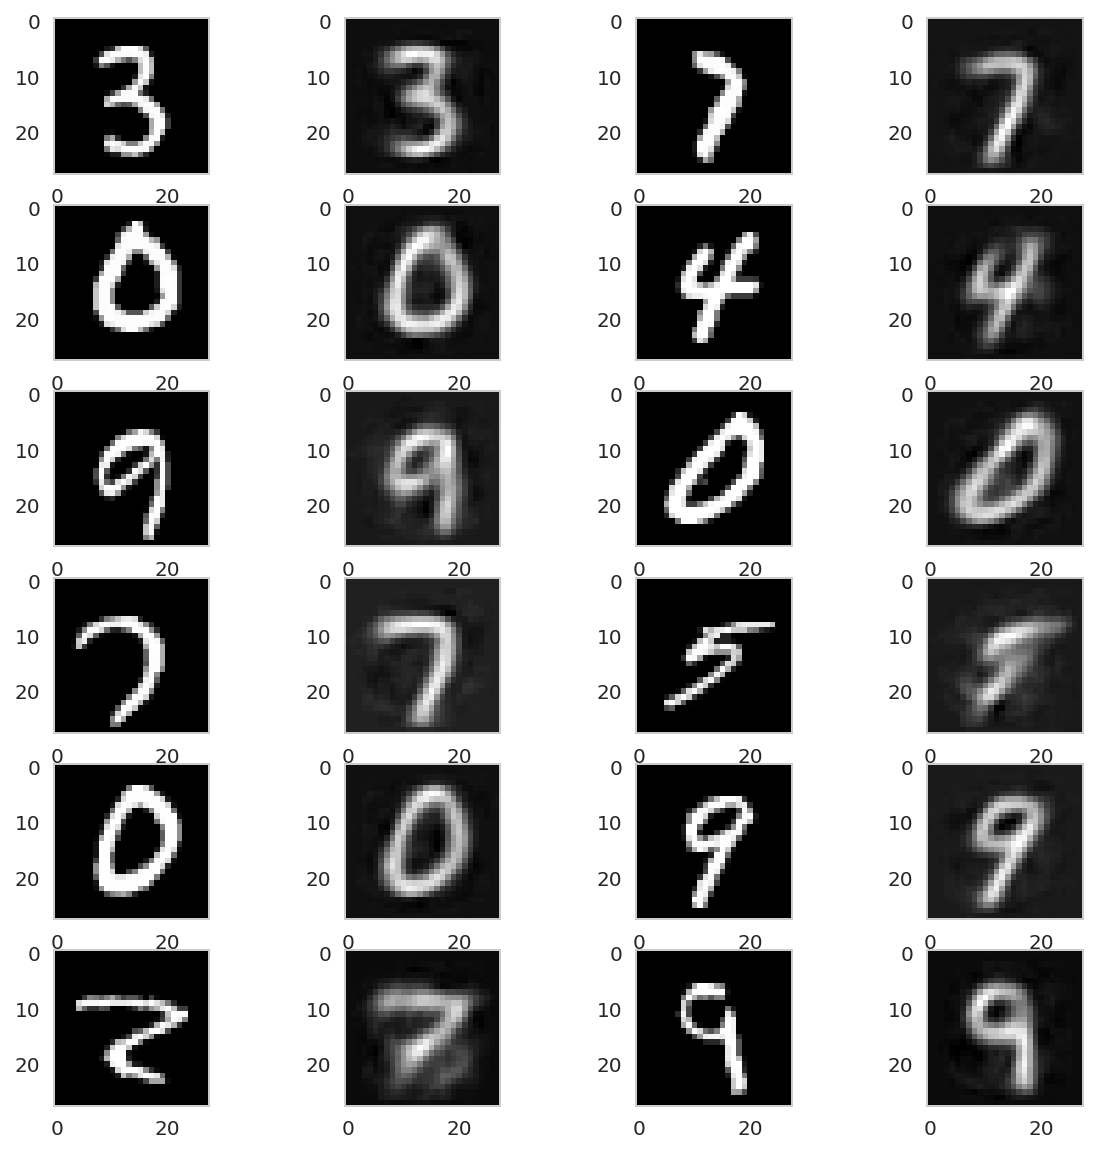

In [377]:
plot_results(data, recon) # 6 linear layers + 1e-6 L1_reg + 800 hid size (best MSE: 2.2240e-2)

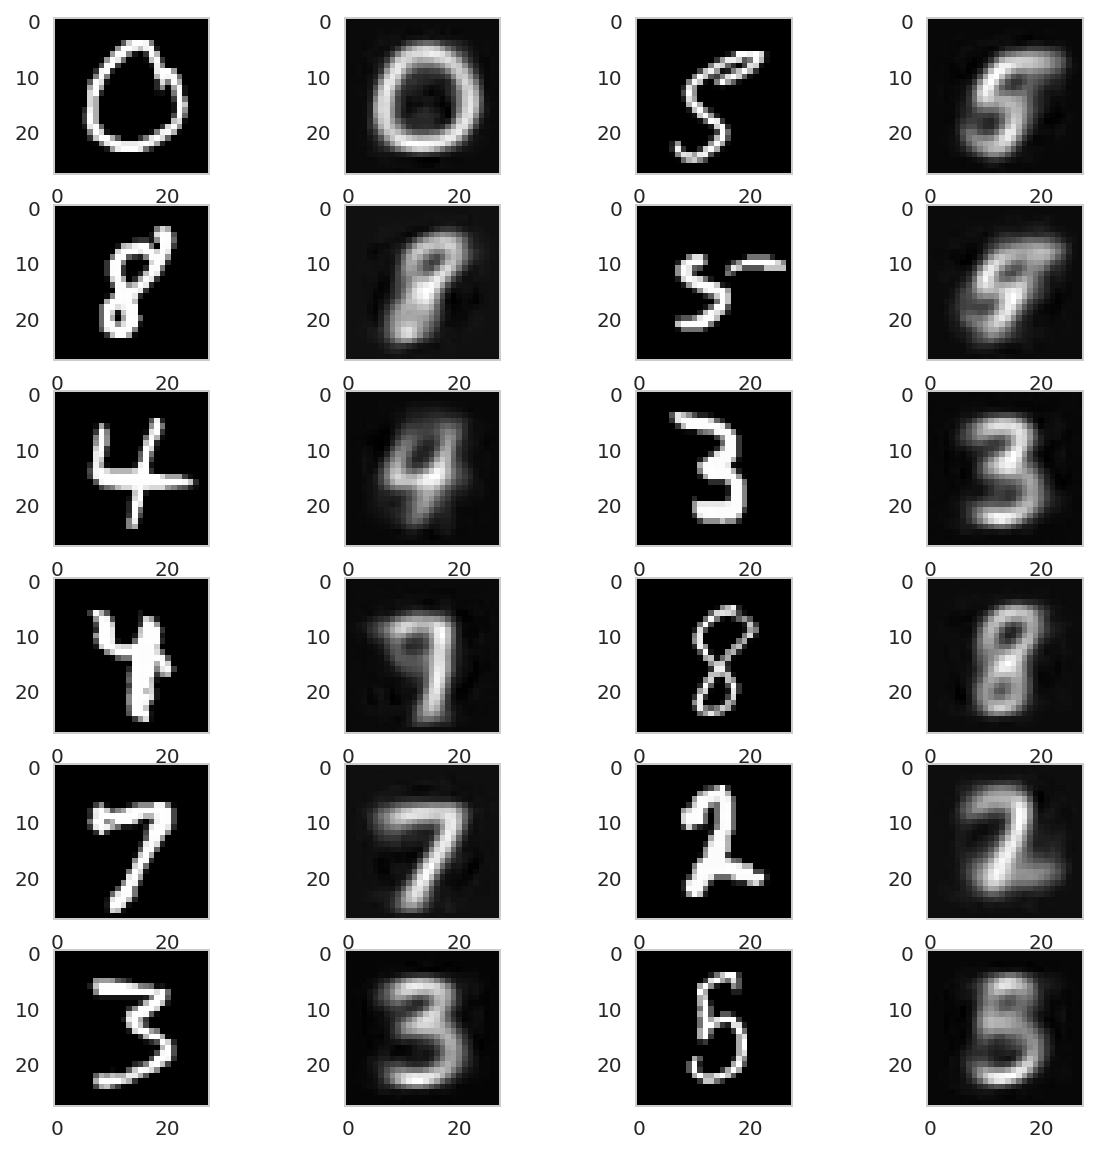

In [355]:
plot_results(data, recon) # 6 linear layers + 1e-6 L1_reg + 300/100 hid size

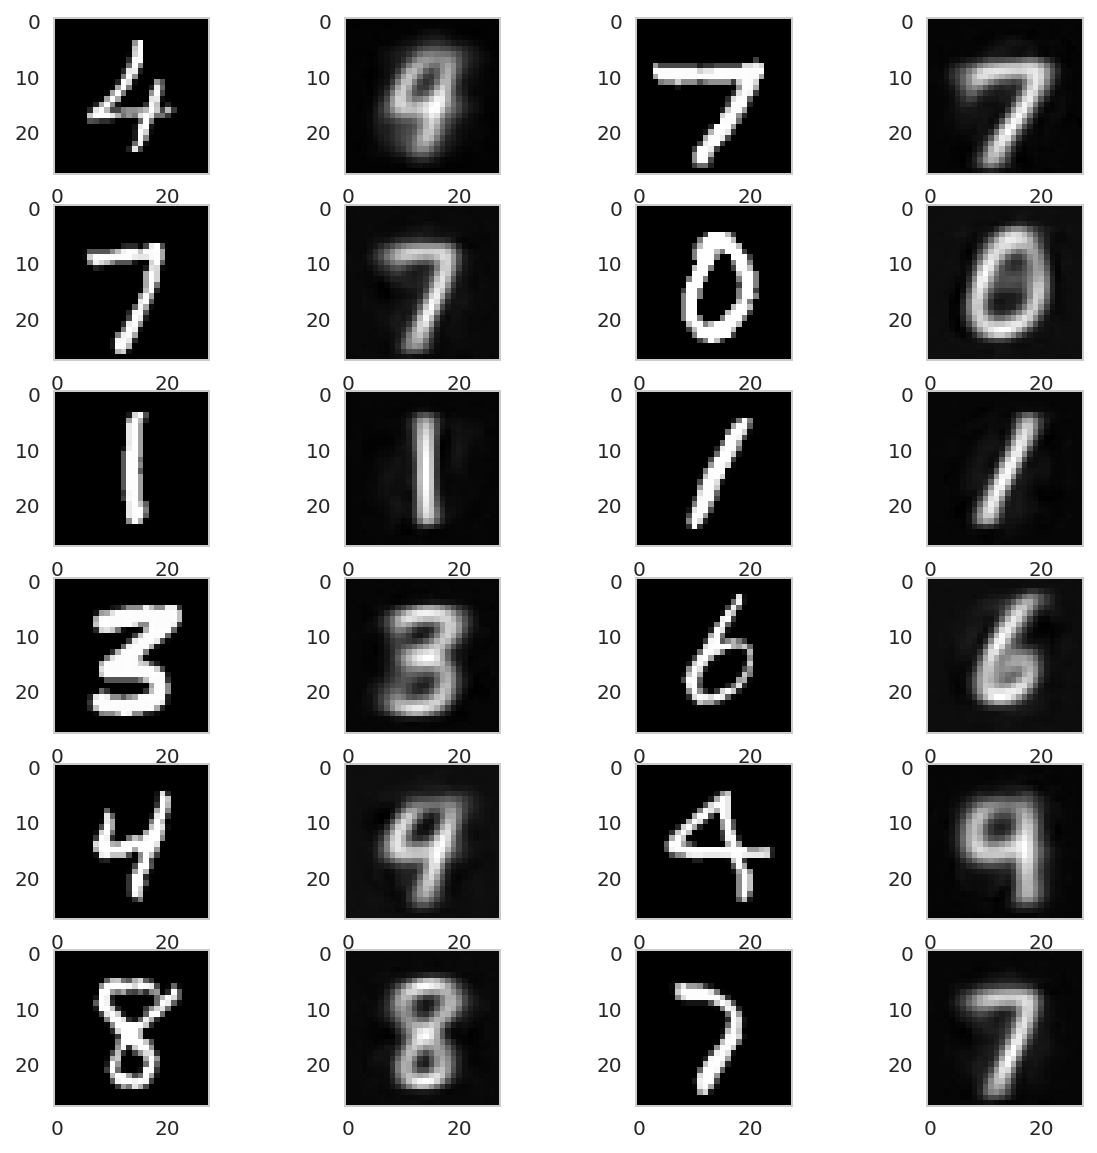

In [251]:
plot_results(data, recon) # 6 linear layers + GPU (3.3628 MSE)

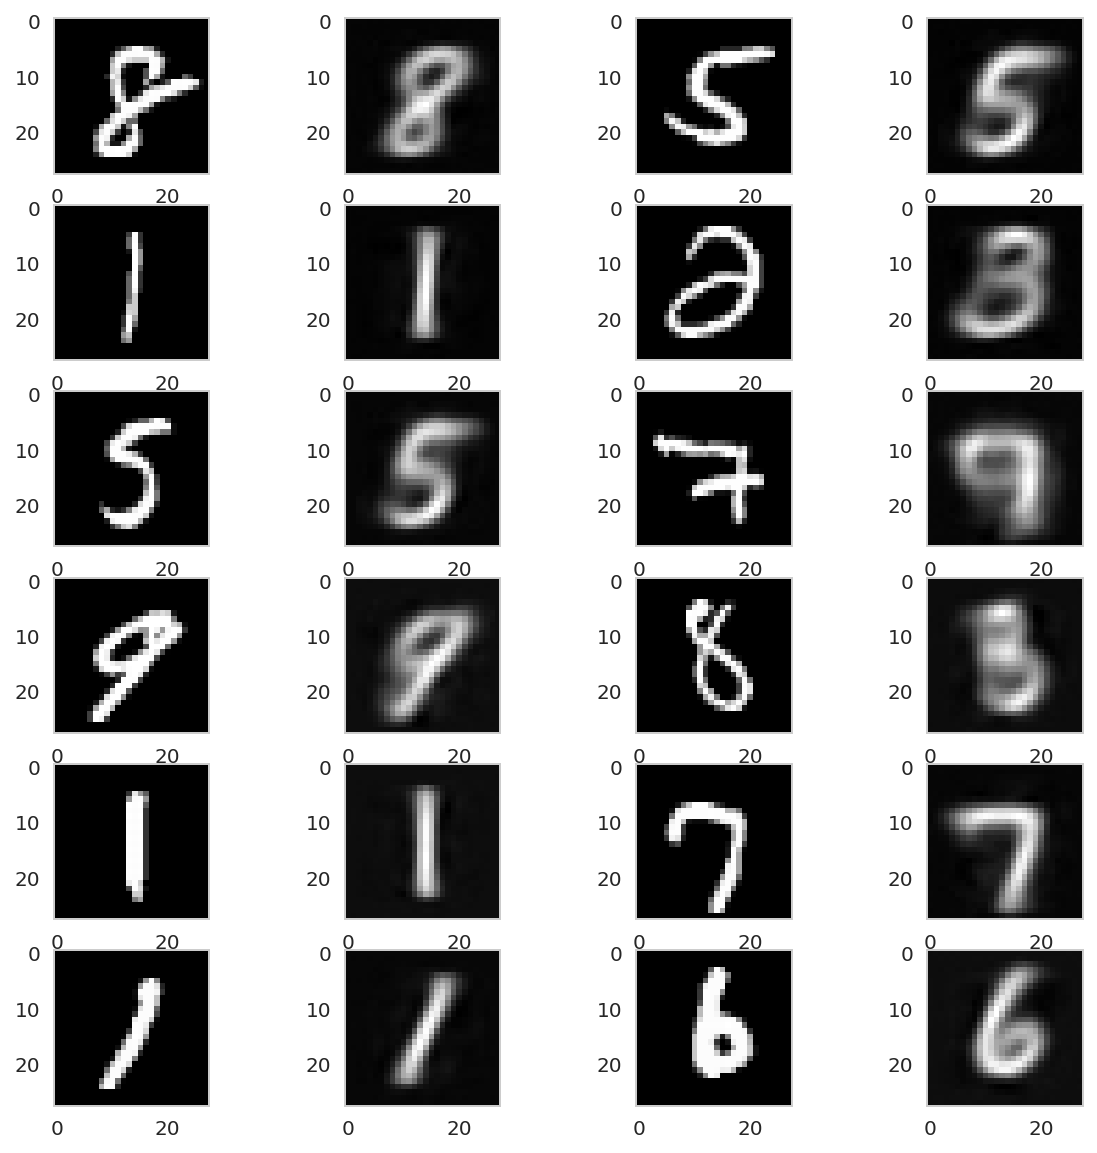

In [244]:
plot_results(data, recon) # 6 linear layers + GPU (3.3628 MSE)

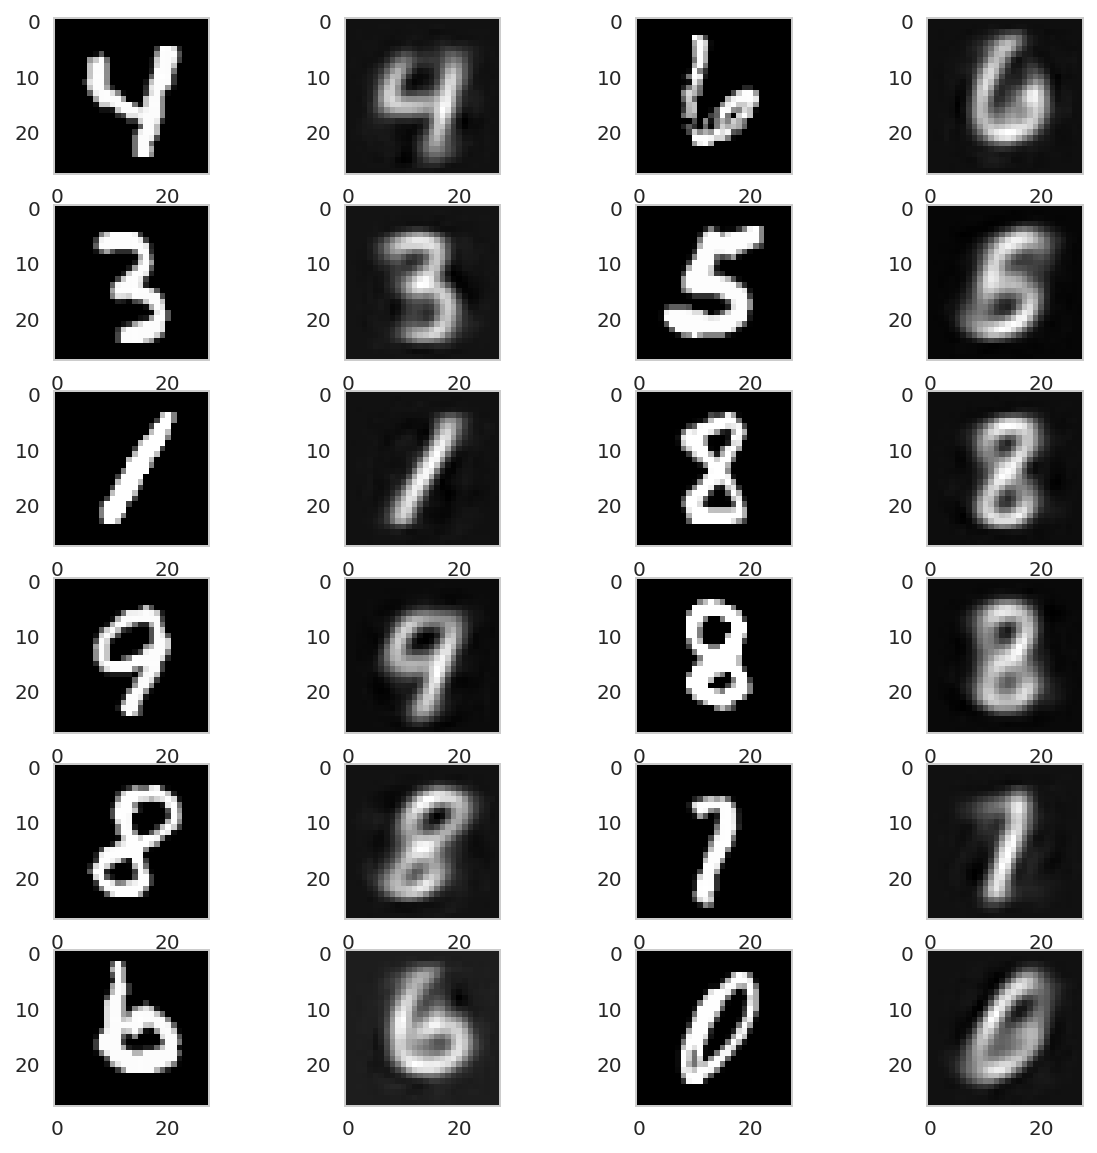

In [212]:
plot_results(data, recon) # 6 linear layers + batch norm + GPU

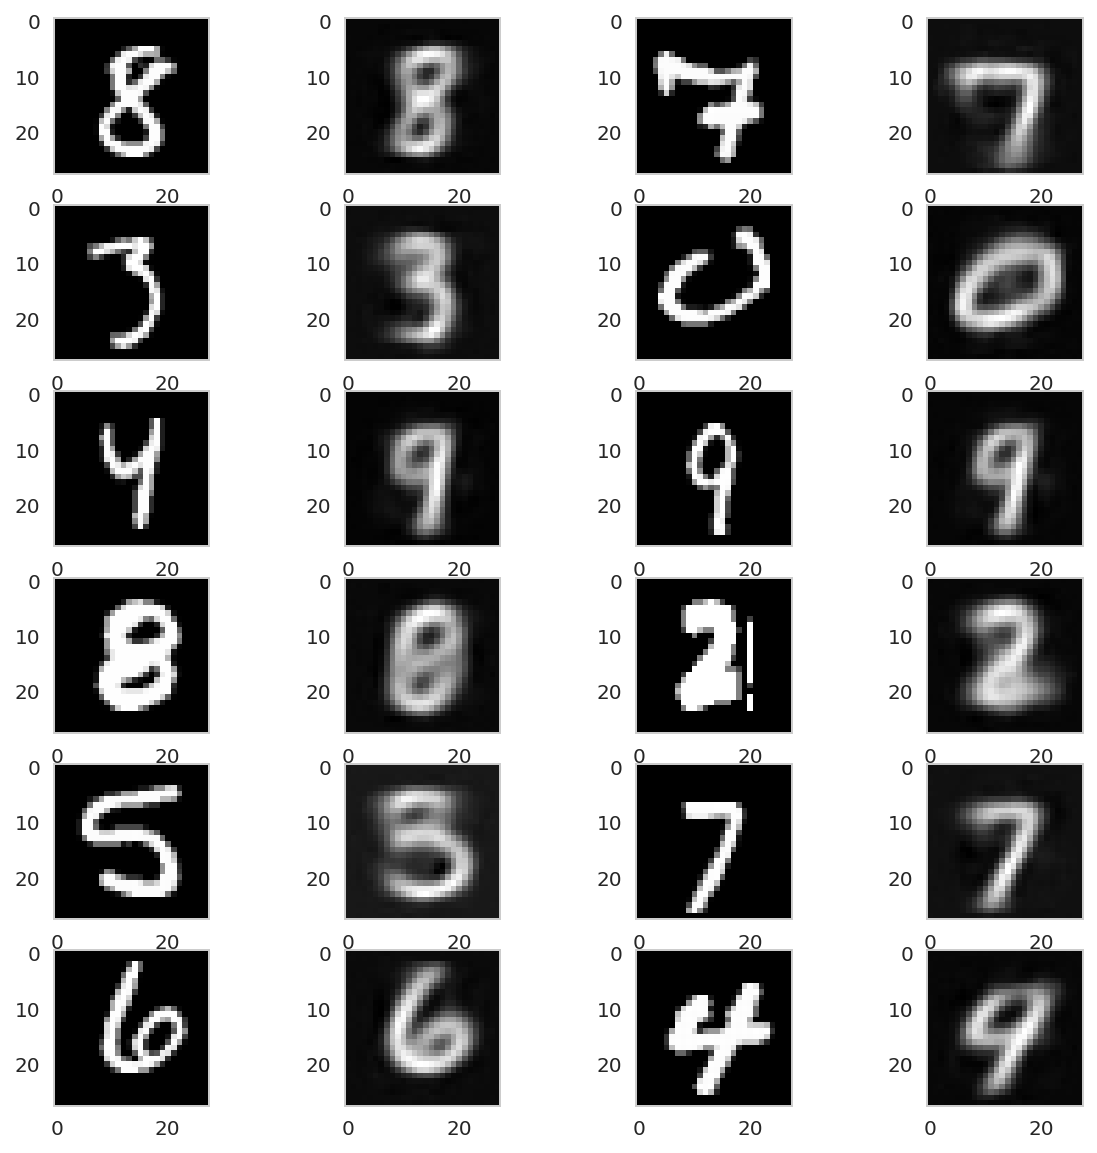

In [170]:
plot_results(data, recon) # 6 linear layers

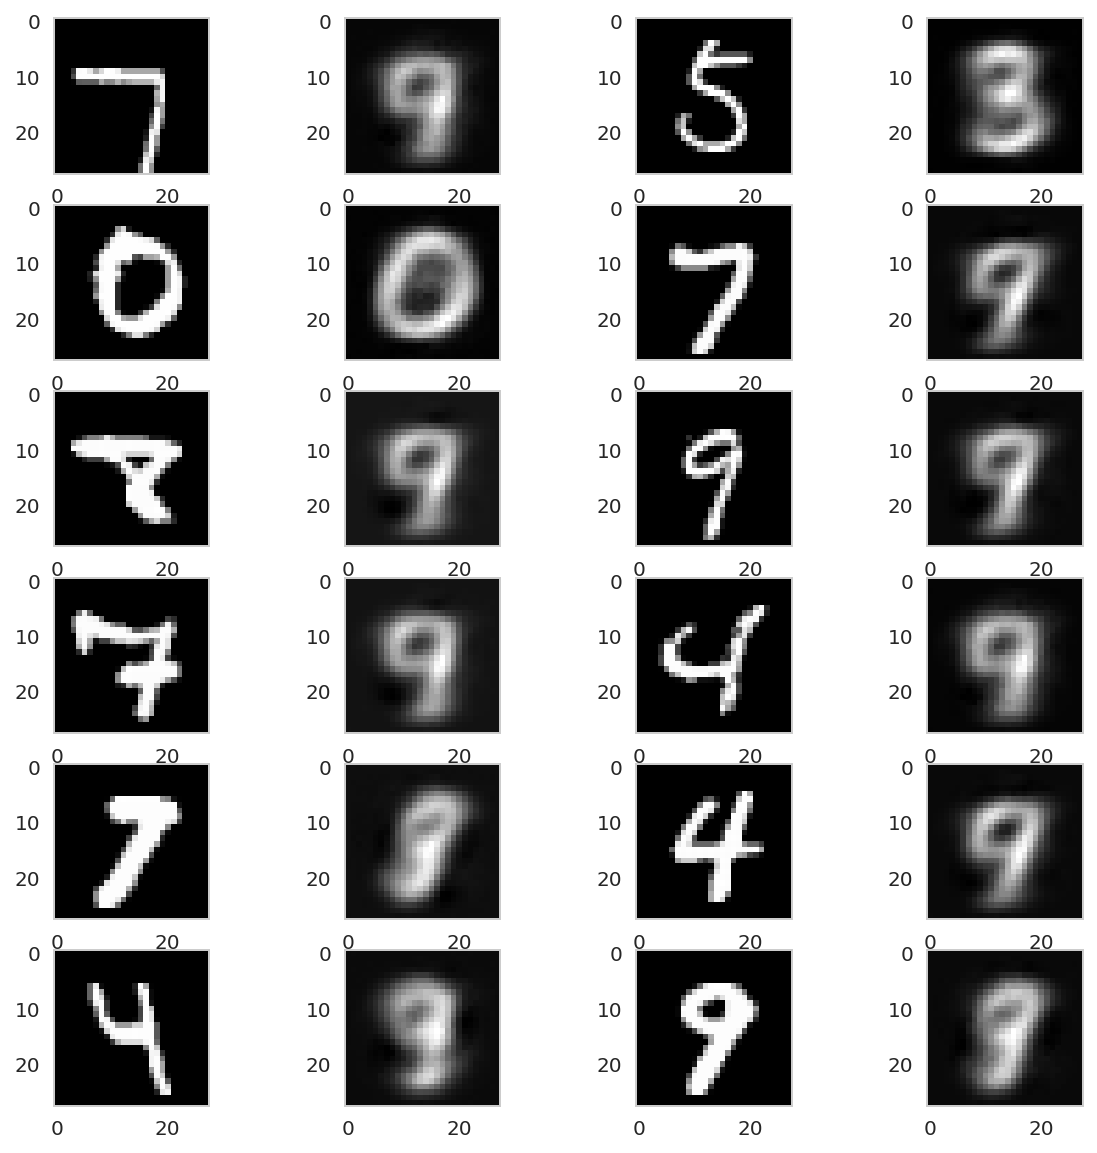

In [140]:
plot_results(data, recon) # 0.2 dropout, no l1_reg

## Visualization

In [400]:
test_data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
        batch_size=50, shuffle=True)

In [401]:
codes = []
targets = []
autoencoder.eval()
for data, target in test_data:
    data = Variable(data, volatile=True).view(-1, 784).cuda()
    codes.append(autoencoder.encode(data).data.cpu().numpy())
    targets.append(target.numpy())
codes = np.array(codes).reshape(-1, 20)
targets = np.array(targets).reshape(-1)

In [405]:
codes.shape, targets.shape

((10000, 20), (10000,))

In [407]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, verbose=3).fit_transform(codes)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.018s...
[t-SNE] Computed neighbors for 10000 samples in 3.422s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.226592
[t-SNE] Computed conditional probabilities in 0.332s
[t-SNE] Iteration 50: error = 97.2775040, gradient norm = 0.0020830 (50 iterations in 9.551s)
[t-SNE] It

In [409]:
X_tsne.shape

(10000, 2)

In [408]:
import numpy as np
np.save('data/X_tsne.npy', X_tsne)

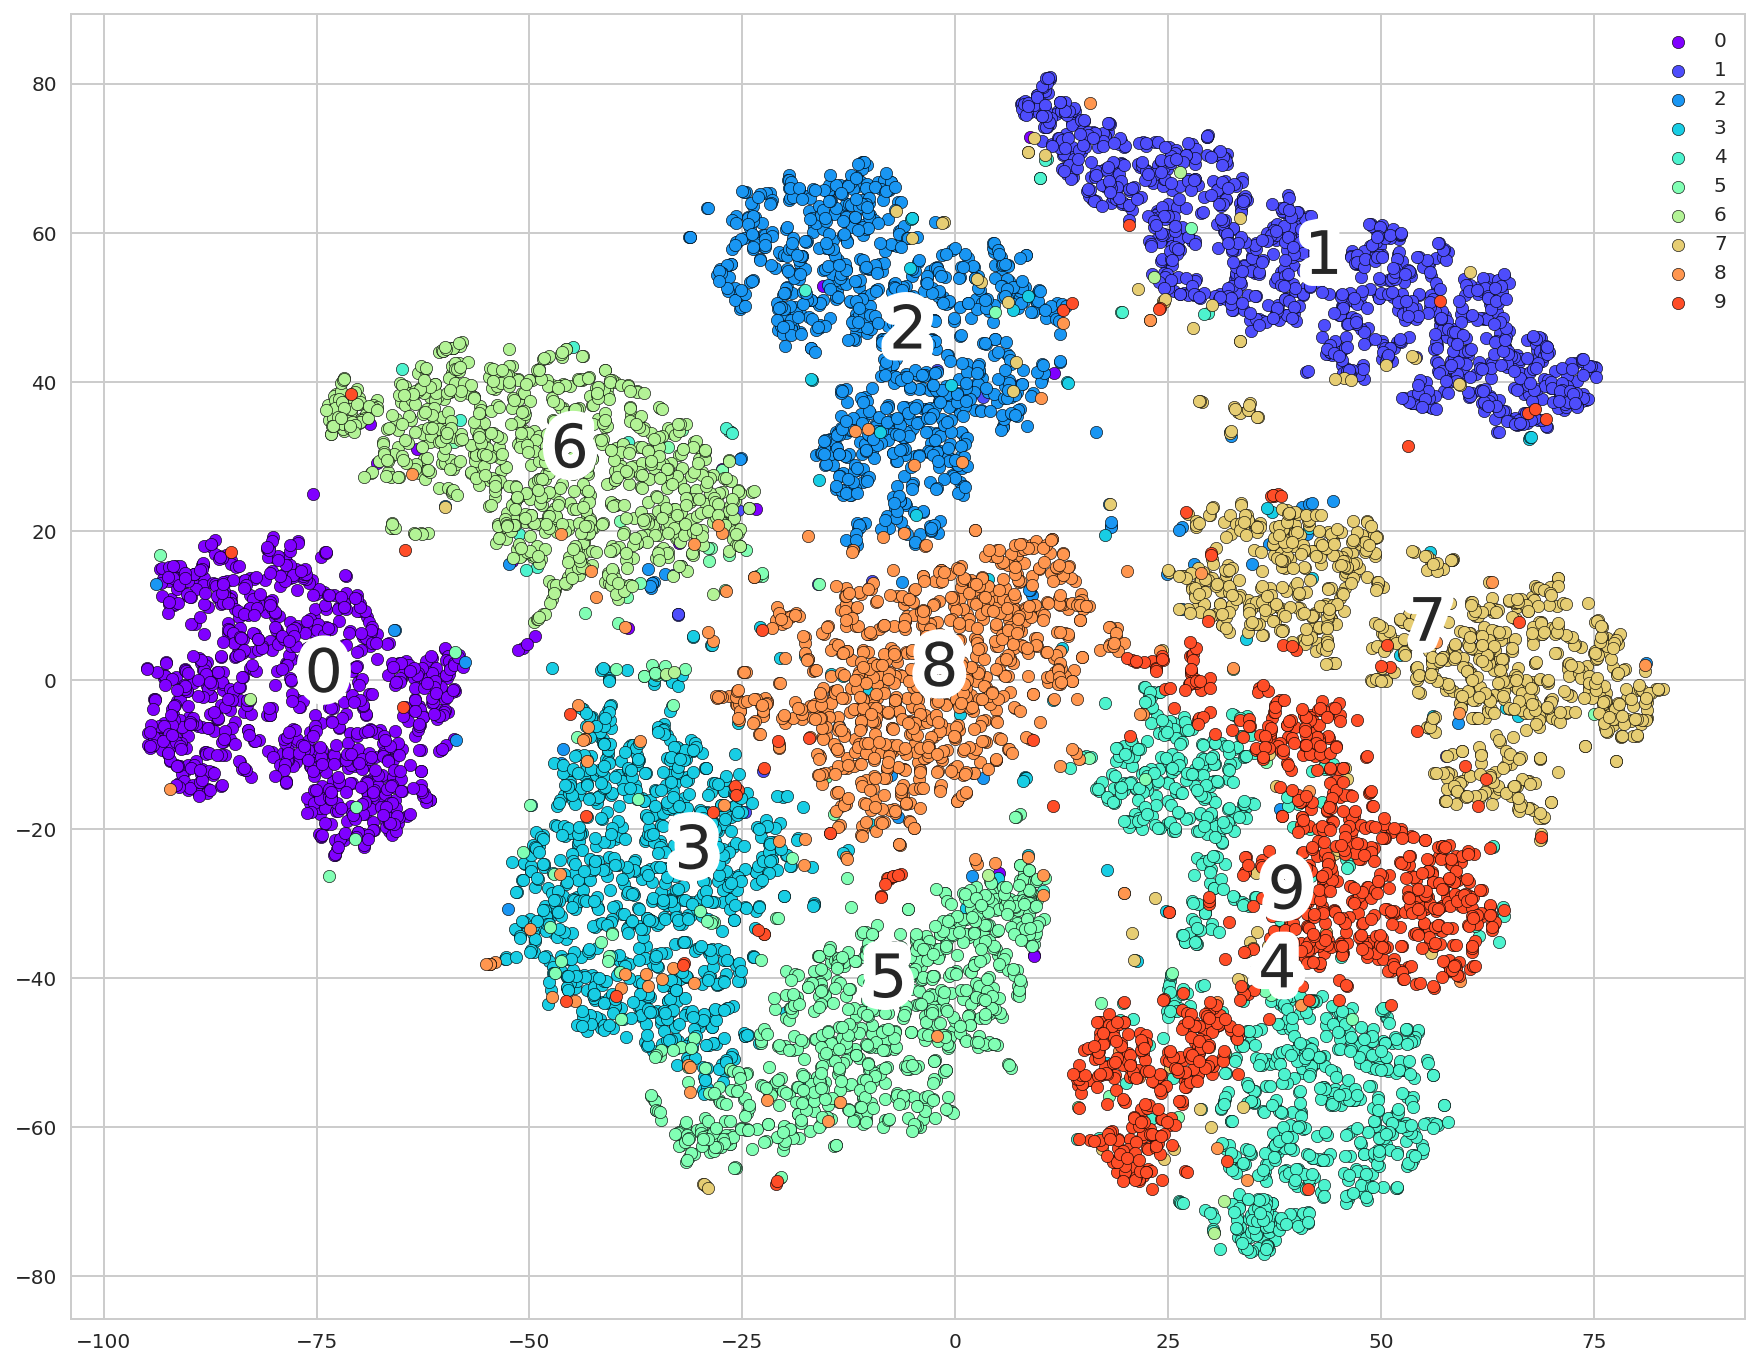

In [453]:
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects

colors = cm.rainbow(np.linspace(0,0.9,10))
fig, ax = plt.subplots(figsize=(15,12))
for i in range(10):
    X_plot = np.array([x for x, t in zip(X_tsne, targets) if t==i])
    ax.scatter(X_plot[:,0], X_plot[:,1], marker='.', c=colors[i], 
                edgecolor='k', s=150, label=i)
    text = ax.text(np.mean(X_plot[:,0]), np.mean(X_plot[:,1]), str(i), 
                   fontdict={'size': 30})
    text.set_path_effects([PathEffects.withStroke(linewidth=12, foreground='w')])
ax.legend(prop={'size': 10})
ax.grid(True)